## 对orders表的数据分析

In [17]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# 导入orders
IDIR = "E:\\Projects\\kaggle\\Instacart\\data\\"
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])


loading prior
loading train
loading orders
loading products


In [46]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [5]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [11]:
# 各个子集的数量
set_cnt =  orders.groupby(orders['eval_set'])['order_id'].count()
for idx in set_cnt.index:
    print(idx, set_cnt[idx])

prior 3214874
test 75000
train 131209


In [5]:
# 各个子集的用户量
set_usr = orders.groupby(orders['eval_set'])['user_id'].nunique()
for idx in set_usr.index:
    print(idx, set_usr[idx])

prior 206209
test 75000
train 131209


所以orders中的数据是：
* prior 用户以前的下单数据
* train 用户的倒数第二单的数据
* test  用户最近一次的订单数据

目标是通过prior和train的训练，对test做出预测


In [22]:
# prior子集和train子集中的order_number
prior_ordnum = orders_prior.groupby(orders_prior['user_id'])[['order_number']].max()
train_ordnum = orders_train.groupby(orders_train['user_id'])[['order_number']].max()

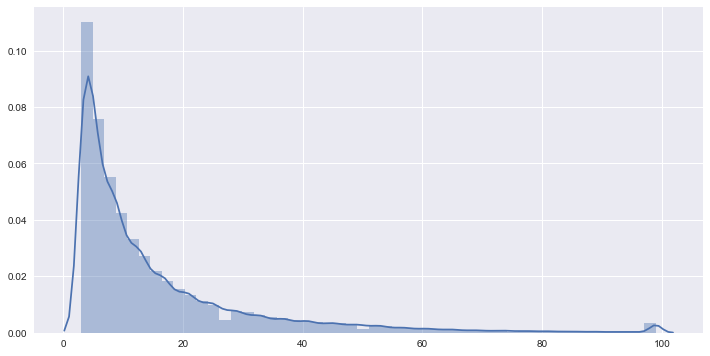

In [38]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(prior_ordnum, ax=ax0)

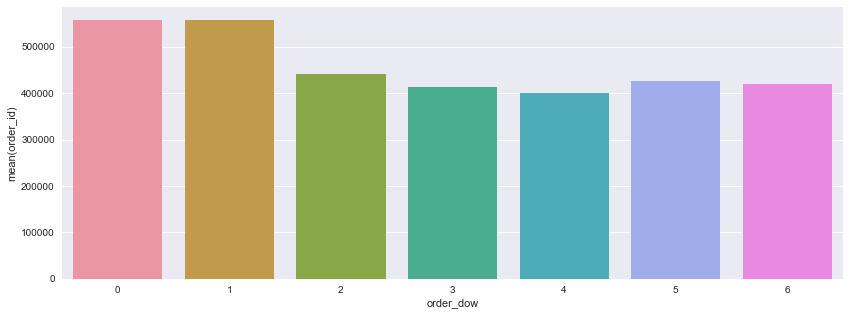

In [75]:
dow = orders_prior.groupby(orders_prior['order_dow'])['order_id'].count().to_frame().reset_index()
plt.figure(figsize=(14,5))
sns.barplot(data=dow, x='order_dow', y='order_id')

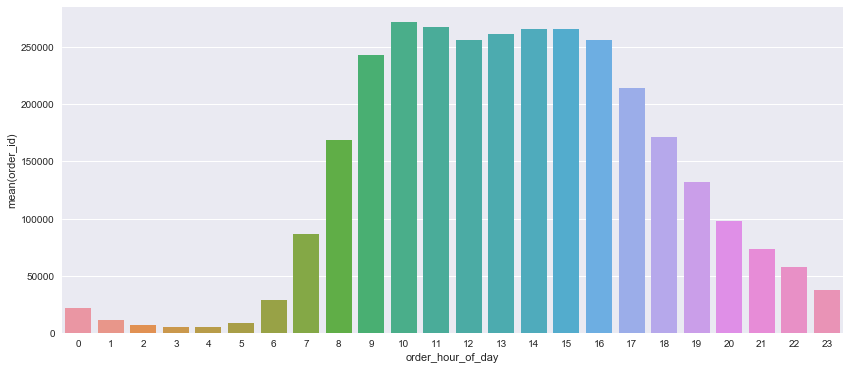

In [74]:
hour = orders_prior.groupby(orders_prior['order_hour_of_day'])['order_id'].count().to_frame().reset_index()
plt.figure(figsize=(14,6))
sns.barplot(data=hour, x='order_hour_of_day', y='order_id')

大家都在工作时间下单吗…

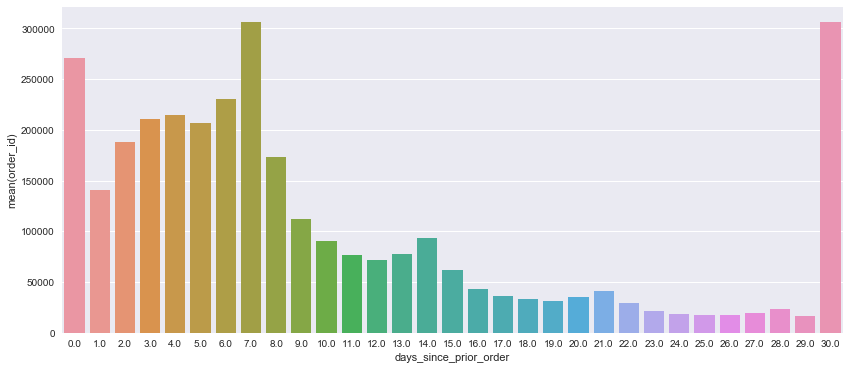

In [73]:
# days_since_prior_order
days_since_prior_order = orders_prior.groupby(orders_prior['days_since_prior_order'])['order_id'].count().to_frame().reset_index()
plt.figure(figsize=(14,6))
sns.barplot(data=days_since_prior_order, x='days_since_prior_order', y='order_id')

最后的30天的高峰，个人认为是将 $days\_since\_prior\_order \ge 30$ 的订单都统一为30了

## orders-products 数据分析

In [7]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [16]:
# prior 连接 orders 信息
orders = orders.set_index('order_id')
prior = pd.merge(prior, orders[orders['eval_set']=='prior'], left_on='order_id', right_index=True, how='inner', suffixes=('_x', '_y'))
prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [18]:
# 用户购物量 vs 用户订单量
user_prods  = prior.groupby('user_id')['product_id'].count()
user_prod_unique = prior.groupby('user_id')['product_id'].nunique()
user_orders = prior.groupby('user_id')['order_id'].nunique()

# 用户平均购物量
user_basket_size = user_prods / user_orders

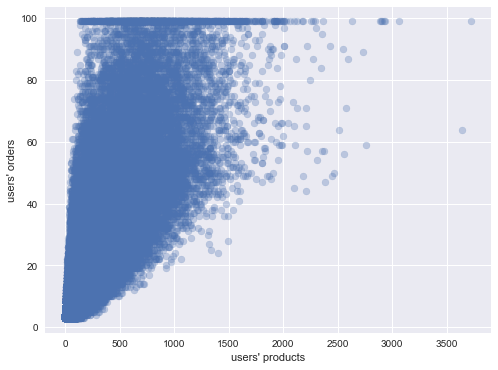

In [73]:
# 购物量 vs 订单量
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(user_prods, user_orders, alpha=0.3)
ax.set(xlabel='users\' products', ylabel='users\' orders')

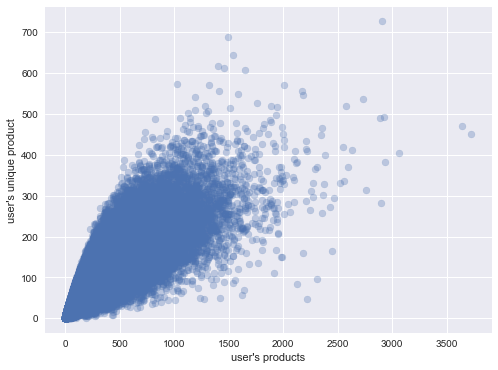

In [74]:
# 购物量 vs 购买商品数
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(user_prods, user_prod_unique, alpha=0.3)
ax.set(xlabel='user\'s products', ylabel='user\'s unique product')

In [56]:
# 用户复购
# user_reord_cnt  = pd.pivot_table(data=prior, index='user_id', columns='reordered', values='product_id', aggfunc=len)
user_reord_rate = prior.groupby('user_id')['reordered'].mean()

In [55]:
user_reord_cnt.head()

reordered,0,1
user_id,,
1,18.0,41.0
2,102.0,93.0
3,33.0,55.0
4,17.0,1.0
5,23.0,14.0


In [57]:
user_reord_rate.head()

user_id
1    0.694915
2    0.476923
3    0.625000
4    0.055556
5    0.378378
Name: reordered, dtype: float64

In [30]:
user_prods.head()

user_id
1     59
2    195
3     88
4     18
5     37
Name: product_id, dtype: int64

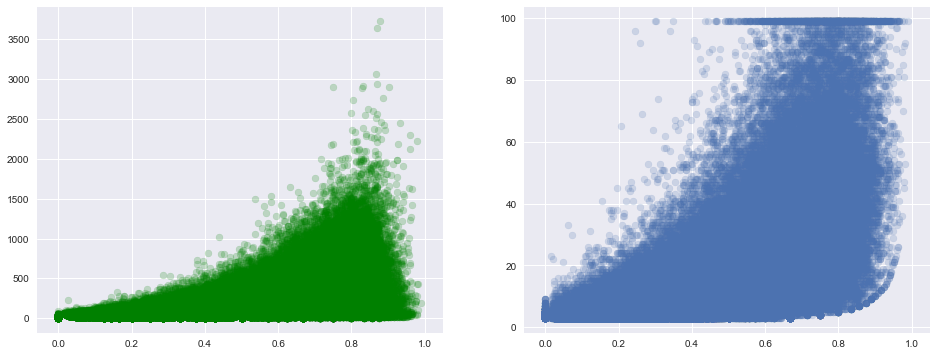

In [84]:
# 复购率 vs 购物量 / 订单量
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.scatter(user_reord_rate, user_prods, alpha=0.2, color='g')
ax2.scatter(user_reord_rate, user_orders, alpha=0.2)

In [59]:
# 加入订单的顺序 vs 重复购买
add_to_cart_reord = prior.groupby('add_to_cart_order')['reordered'].count()

In [66]:
prior.shape

(32434489, 10)

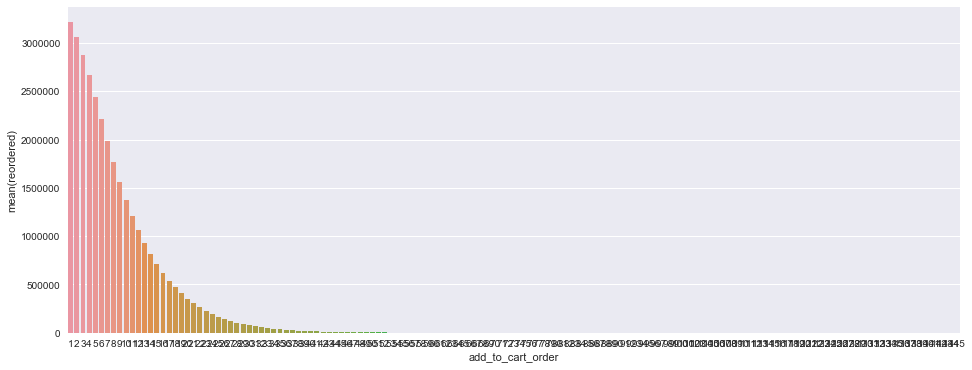

In [68]:
plt.figure(figsize=(16,6))
barplot = sns.barplot(data=add_to_cart_reord.reset_index(), x='add_to_cart_order', y='reordered')
# barplot.invert_yaxis()

## 尝试从多个不同的角度分析更多的数据

**用户特征**

购物量, 订单量, 购买商品频率, 购买趋势, 购物的ailse数, 购物的department数, 订单频率, recency of orders, 用户生命时长, 平均购物篮大小, etc.

**商品特征**

用户数, 订单量, 订单频率, 复购率, 购买趋势, 平均加入购物篮序数, etc.

**Aisle and Department Features**

用户数, 订单量, 订单频率, 复购率, 购买趋势, 平均加入购物篮序数, etc.

**用户-商品交叉**

购买量, 订单量, 最近一次购买后天数, 最近一次购买后订单量 etc.

**用户-aisle交叉**

同上

**用户购物时间偏好**

用户的购物时间偏好，day of week, time of day


### 1. 用户特征

购物量, 订单量, 购买商品频率, 购买趋势, 购物的ailse数, 购物的department数, 订单频率, recency of orders, 用户生命时长, 平均购物篮大小, etc.


In [11]:
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)


add order info to priors


In [12]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [30]:
# 订单量
user_total_orders = orders.groupby('user_id').size().astype(np.int16)

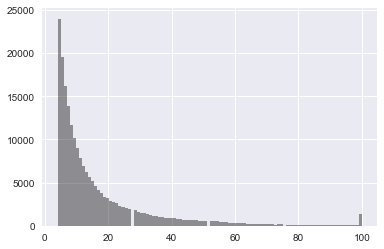

In [32]:
sns.distplot(user_total_orders, kde=False, bins=100, color='black')

In [34]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [35]:
# 购物量
user_total_products = priors.groupby('user_id').size().astype(np.int16)

# 购买商品数
user_distinct_products = priors.groupby('user_id')['product_id'].nunique().astype(np.int16)

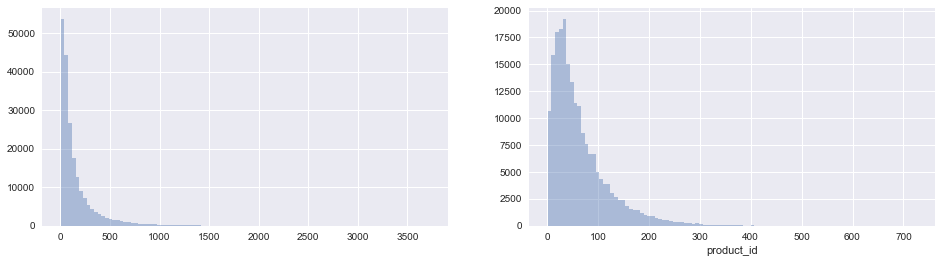

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
sns.distplot(user_total_products, kde=False, bins=100, ax=ax1)
sns.distplot(user_distinct_products, kde=False, bins=100, ax=ax2)

In [41]:
# 平均购物篮大小
user_basket_size = user_total_products / user_total_orders
user_basket_size.head()

user_id
1     5.363636
2    13.000000
3     6.769231
4     3.000000
5     7.400000
dtype: float64

In [42]:
# 订单周期/频率
user_order_period = priors.groupby('user_id')['days_since_prior_order'].mean().astype(np.float16)

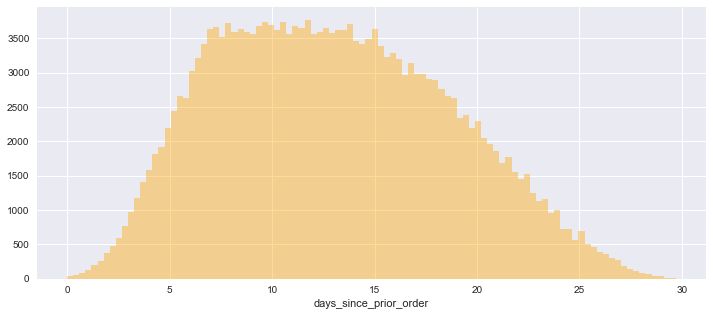

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
sns.distplot(user_order_period, kde=False, bins=100, ax=ax, color='orange')

In [25]:
user_total_orders[user_total_orders > 1000].shape

(2090,)

## 关于交叉验证

[What is a training data set & test data set in machine learning? What are the rules for selecting them?](https://www.quora.com/What-is-a-training-data-set-test-data-set-in-machine-learning-What-are-the-rules-for-selecting-them)

[What is the difference between test set and validation set?](https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set)

## 参考资料

[Exploratory Analysis - Instacart](https://www.kaggle.com/philippsp/exploratory-analysis-instacart) by Philipp Spachtholz



[Repeat Buyer Prediction for E-Commerce](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwimkdP475nVAhVorlQKHUycB0YQFggjMAA&url=http%3A%2F%2Fwww.kdd.org%2Fkdd2016%2Fpapers%2Ffiles%2Fadf0160-liuA.pdf&usg=AFQjCNH0nM_qyLyiZzmOZKPhviCJPgGIhg)

[A Dynamic Recurrent Model for Next Basket Recommendation](http://www.nlpr.ia.ac.cn/english/irds/People/sw/DREAM.pdf)

[Factorizing Personalized Markov Chains for Next-Basket Recommendation](https://www.ismll.uni-hildesheim.de/pub/pdfs/RendleFreudenthaler2010-FPMC.pdf)

[Next Basket Prediction using Recurring Sequential Patterns](https://arxiv.org/pdf/1702.07158.pdf)
